# Quick Start with MAPIE

This package allows you to easily estimate uncertainties in both regression and classification settings.

- In regression settings, MAPIE provides prediction intervals on single-output data.
- In classification settings, MAPIE provides prediction sets on multi-class data.

In any case, MAPIE is compatible with any scikit-learn-compatible estimator.

## 1. Download and install the package

In [1]:
!pip install mapie

In [2]:
from utils.config import SMALL_FIGSIZE, MEDIUM_FIGSIZE, LARGE_FIGSIZE
import numpy as np
import seaborn as sns

np.random.seed(42)

## 2. Run MapieRegressor

Let us start with a basic regression problem. Here, we generate one-dimensional noisy data that we fit with a linear model.

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Get datasets.
X, y = make_regression(n_samples=500, n_features=1, noise=20, random_state=59)
X_train_calib, X_test, y_train_calib, y_test = train_test_split(X, y, test_size=0.5)

# Get main predictor.
regressor = LinearRegression()

Since MAPIE is compliant with the standard scikit-learn API, we follow the standard sequential fit and predict process like any scikit-learn regressor.

We set two values for alpha to estimate prediction intervals at approximately one and two standard deviations from the mean.

In [4]:
from mapie.regression import MapieRegressor

# Wrap it with MAPIE conformal class.
mapie_regressor = MapieRegressor(regressor)

# Conformalize the main predictor (compute conformity scores on calibration data).
mapie_regressor.fit(X_train_calib, y_train_calib)

# Obtain predictions and prediction sets.
alpha = [0.05, 0.32]
y_pred, y_pis = mapie_regressor.predict(X_test, alpha=alpha)

MAPIE returns a np.ndarray of shape (n_samples, 2, len(alpha)) giving the predictions, as well as the lower and upper bounds of the prediction intervals for the target quantile for each desired alpha value.

You can compute the coverage of your prediction intervals.

In [5]:
from mapie.metrics import regression_coverage_score_v2

# Compute the coverage score.
coverage_scores = regression_coverage_score_v2(y_test, y_pis)

The estimated prediction intervals can then be plotted as follows.

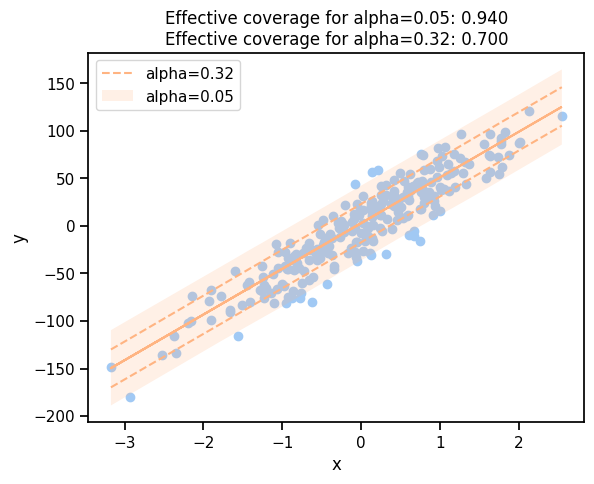

In [6]:
from matplotlib import pyplot as plt

# Plot the test data points
plt.scatter(X_test, y_test)

# Plot the prediction lines
plt.plot(X_test, y_pred, color="C1")

# Plot the prediction intervals
order = np.argsort(X_test[:, 0])
plt.plot(X_test[order], y_pis[order][:, 0, 1], color="C1", ls="--")
plt.plot(X_test[order], y_pis[order][:, 1, 1], color="C1", ls="--", label='alpha=0.32')
plt.fill_between(
    X_test[order].ravel(),
    y_pis[order][:, 0, 0].ravel(),
    y_pis[order][:, 1, 0].ravel(),
    alpha=0.2, label='alpha=0.05'
)

# Add annotations
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title(
    f"Effective coverage for "
    f"alpha={alpha[0]:.2f}: {coverage_scores[0]:.3f}\n"
    f"Effective coverage for "
    f"alpha={alpha[1]:.2f}: {coverage_scores[1]:.3f}"
)
plt.show()

The title of the plot compares the target coverages with the effective coverages.
- The target coverage, or the confidence interval, is the fraction of true labels lying in the prediction intervals that we aim to obtain for a given dataset. It is given by the alpha parameter defined in MapieRegressor, here equal to 0.05 and 0.32, thus giving target coverages of 0.95 and 0.68.
- The effective coverage is the actual fraction of true labels lying in the prediction intervals.

## 3. Run MapieClassifier

Similarly, it’s possible to do the same for a basic classification problem.

Let us start with a basic classification problem. Here, we generate two-dimensional noisy data grouped into three classes that we fit with a logistic regression model.

In [7]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Get datasets.
X, y = make_blobs(n_samples=500, n_features=2, centers=3)
X_train_calib, X_test, y_train_calib, y_test = train_test_split(X, y, test_size=0.5)

# Get main predictor.
classifier = LogisticRegression()


Since MAPIE is compliant with the standard scikit-learn API, we follow the standard sequential fit and predict process like any scikit-learn classifier.

We set one value for alpha to estimate prediction sets.

In [8]:
from mapie.classification import MapieClassifier

# Wrap it with MAPIE conformal class.
mapie_classifier = MapieClassifier(estimator=classifier, method='score', cv=5)

# Conformalize the main predictor (compute conformity scores on calibration data).
mapie_classifier = mapie_classifier.fit(X_train_calib, y_train_calib)

# Obtain predictions and prediction sets.
alpha = 0.1
y_pred, y_pis = mapie_classifier.predict(X_test, alpha=alpha)

MAPIE returns a np.ndarray of shape (n_samples, n_classes, len(alpha)) giving the predictions, as well as the predictions sets (boolean array) for each desired alpha value.

You can compute the coverage of your prediction sets.

In [9]:
from mapie.metrics import classification_coverage_score_v2

# Compute the coverage score.
coverage_scores = classification_coverage_score_v2(y_test, y_pis)

The estimated prediction sets can then be plotted as follows.

In [10]:
set_list = {'001': 0, '010': 1, '100': 2, '000': 3}
label_list = {i: label for i, label in enumerate(mapie_classifier.classes_)}

def transform_set_to_label(arr):
    convert_array = lambda x: set_list[''.join([str(int(elt)) for elt in x])]
    return np.apply_along_axis(convert_array, axis=1, arr=arr)

set2color = {code: sns.color_palette("pastel").as_hex()[i] for i, code in enumerate(set_list)}
set2color['000'] = '#eeeeee'
label2color = {code: sns.color_palette("pastel").as_hex()[i] for i, code in enumerate(label_list)}

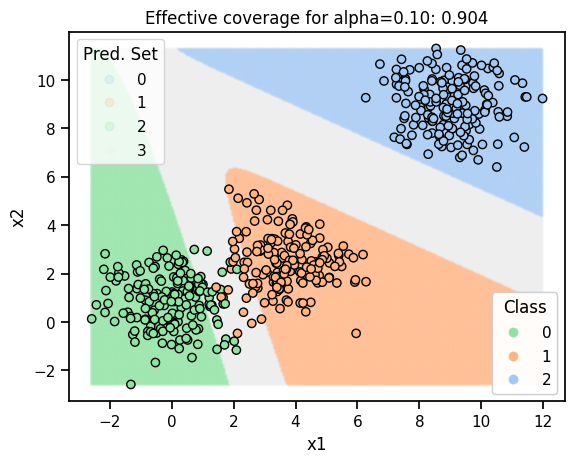

In [11]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots()

# Create a meshgrid to plot the prediction sets
x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
step = 0.05

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
X_test_mesh = np.stack([xx.ravel(), yy.ravel()], axis=1)

# Plot the prediction sets
y_pis = mapie_classifier.predict(X_test_mesh, alpha=alpha)[1][:,:,0]

scatter = plt.scatter(
    X_test_mesh[:, 0], X_test_mesh[:, 1],
    c=transform_set_to_label(y_pis),
    marker='.', s=10, alpha=0.2,
    cmap=ListedColormap(list(set2color.values())),
)
legend2 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Pred. Set")
ax.add_artist(legend2)

# Plot the test data points
scatter = ax.scatter(
    X[:, 0], X[:, 1], c=y, edgecolors='black',
    cmap=ListedColormap(list(label2color.values())[::-1]),
)
legend1 = ax.legend(*scatter.legend_elements(), loc="lower right", title="Class")
ax.add_artist(legend1)

# Add annotations
plt.xlabel("x1")
plt.ylabel("x2")
plt.title(
    f"Effective coverage for "
    f"alpha={alpha:.2f}: {coverage_scores[0]:.3f}"
)

plt.show()